In [48]:
import os
from io import open 

"""Writing the data per file into a dictionary for which the key is the category of news"""

import unicodedata
import string

all_letters = string.ascii_letters + ".,;' "
n_letters = len(all_letters)

def unitoAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readFile_byline(filename):
    line_of_news = open("news_data/"+filename , encoding = 'utf-8').read().split('\n')    
    return [unitoAscii(line) for line in line_of_news]

In [49]:
category_news = {}
all_categories = []

list_of_files = os.listdir("news_data/")

#Dictionary which maps every category of news to it's description
for _file in list_of_files:
    category = _file.split(".")[0]
    all_categories.append(category)
    news_descp = readFile_byline(_file)
    category_news[category] = news_descp

num_categories = len(all_categories)

count_of_news_category = {}
average_words_per_number_of_samples = []

#Counting news items per category of news 
for key in category_news.keys():
    item = category_news.get(key)
    number_of_news_items = len(item)
    count_of_news_category[key] = number_of_news_items
    count_of_words = 0
    for sentence in item:
        count_of_words += len(sentence.split(" "))
    average_words_per_number_of_samples.append(count_of_words/number_of_news_items)

#print(count_of_news_category["WELLNESS"])
#print(category_news["CRIME"][0:2])
#print(average_words_per_number_of_samples)

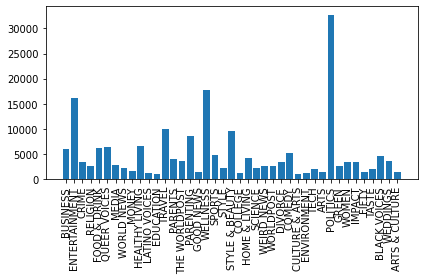

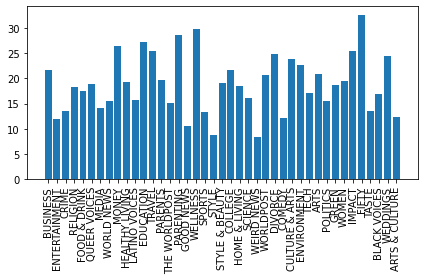

In [50]:
import random
import matplotlib
import matplotlib.pyplot as plt 

fig = plt.figure()
category = count_of_news_category.keys()
value = count_of_news_category.values()
plt.bar(category, value)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Number_of_articles_per_category.png')
plt.show()

fig1 = plt.figure()
category = count_of_news_category.keys()
value = average_words_per_number_of_samples
plt.bar(category, value)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Words_per_category.png')
plt.show()


In [51]:
import torch
import torch.nn as nn 
from torch import optim
import torch.functional as F 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)

def findIndexOfWordInSentence(sentence):
    indexOfWord = {}
    for index, word in enumerate(sentence):
        indexOfWord[word] = index
    return list(indexOfWord.values())

def sentenceToTensor(sentence):
    indexes = findIndexOfWordInSentence(sentence)
    return torch.tensor(indexes , dtype = torch.long, device = device).view(-1, 1)

category_plus_news_list = []

from nltk.corpus import stopwords

for key in category_news.keys():
    for news_item in category_news[key]:
        #news_item = [word for word in news_item.split(" ") if word not in stopwords.words('english')]
        #news_item = " ".join(word for word in news_item)
        category_plus_news_list.append((key, news_item))

print(category_plus_news_list[0])

def pairedTensor(pair):
    #pair is element in category_plus_news_list
    input_tensor = sentenceToTensor(pair[1])
    output_tensor = sentenceToTensor(pair[0])
    return (input_tensor, output_tensor)

#print(pairedTensor(category_plus_news_list[100]))

unique_words = []

'''for pair in category_plus_news_list:
    for word in pair[1].split(" "):
        if word.lower() not in unique_words:
            unique_words.append(word.lower())

print(unique_words[0:50])'''

('BUSINESS', 'The investigation could lead to new U.S. tariffs similar to those imposed on imported steel and aluminum in March.')


'for pair in category_plus_news_list:\n    for word in pair[1].split(" "):\n        if word.lower() not in unique_words:\n            unique_words.append(word.lower())\n\nprint(unique_words[0:50])'

In [52]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("bert-base-nli-mean-tokens")




sentence_embeddings = model.encode(category_plus_news_list[0][1])
print(category_plus_news_list[0][1])
print(sentence_embeddings)

The investigation could lead to new U.S. tariffs similar to those imposed on imported steel and aluminum in March.
[ 1.34353526e-02 -1.53605297e-01  1.02039182e+00  3.21564600e-02
  4.77839887e-01 -2.61338532e-01 -7.43478537e-01 -2.43426457e-01
  1.53835759e-01 -8.17684472e-01  3.64184290e-01  1.28729299e-01
  3.75241548e-01  3.49925607e-01 -1.02918398e+00 -5.52589148e-02
 -4.31503147e-01 -7.20983669e-02 -3.03760171e-01 -2.69009024e-02
  1.22883320e-01 -3.95876199e-01  9.66541529e-01  3.75788867e-01
  8.45915318e-01 -1.87337041e-01  1.56129092e-01  2.92605132e-01
 -1.12959194e+00 -7.46736079e-02 -7.90211797e-01  5.23193002e-01
 -7.88372278e-01 -1.45080030e-01  1.27687573e-03  1.40462613e+00
 -7.88551092e-01 -2.69031525e-02 -1.20518543e-01 -3.22462052e-01
 -3.33961189e-01 -2.22803101e-01 -2.82952875e-01  3.03717345e-01
 -1.64360154e+00 -4.25611734e-02  2.37799790e-02  3.83549690e-01
 -1.89633697e-01 -9.51271236e-01  2.90132761e-01  5.24523377e-01
  8.63636136e-02  4.33677018e-01 -2.3412

In [53]:
sentence_embeddings.shape

(768,)

In [54]:
from models import InferSent
model_version = 2
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))


use_cuda = True
model = model.to(torch.device('cuda:0')) if use_cuda else model

W2V_PATH = 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)
model.build_vocab_k_words(K=1000000)

Vocab size : 1000000


In [55]:
list_of_sentences_business = []
list_of_sentences_politics = []
list_of_sentences_religion = []
list_of_sentences_food = []
list_of_sentences_home = []

list_of_sentences = []

labels =[]

for pair in category_plus_news_list:
    label = pair[0]
    sentences = pair[1].split(". ")
    for sentence in sentences:
        if len(sentence) >=7:
            list_of_sentences.append(sentence)
            labels.append(label)
    



for pair in category_plus_news_list:
    if pair[0]=='BUSINESS':
        sentences_business = pair[1].split(". ")
        for sentence in sentences_business:
            list_of_sentences_business.append(sentence)
    if pair[0]=='POLITICS':
        sentences_politics = pair[1].split(". ")
        for sentence in sentences_politics:
            list_of_sentences_politics.append(sentence)
    if pair[0]=='RELIGION':
        sentences_religion = pair[1].split(". ")
        for sentence in sentences_religion:
            list_of_sentences_religion.append(sentence)
    if pair[0]=='FOOD & DRINK':
        sentences_food = pair[1].split(". ")
        for sentence in sentences_food:
            list_of_sentences_food.append(sentence)
    if pair[0]=='HOME & LIVING':
        sentences_home = pair[1].split(". ")
        for sentence in sentences_home:
            list_of_sentences_home.append(sentence)
    
        
            

print(len(list_of_sentences))
print(len(labels))




262468
262468


In [56]:
#embeddings_business = model.encode(list_of_sentences_business, bsize=128, tokenize=False, verbose=True)
embeddings = model.encode(list_of_sentences, bsize=128, tokenize=False, verbose=True)
#embeddings_politics = model.encode(list_of_sentences_politics, bsize=128, tokenize=False, verbose=True)
#embeddings_religion = model.encode(list_of_sentences_religion, bsize=128, tokenize=False, verbose=True)
#embeddings_food = model.encode(list_of_sentences_food, bsize=128, tokenize=False, verbose=True)
#embeddings_home = model.encode(list_of_sentences_home, bsize=128, tokenize=False, verbose=True)
#print('nb sentences encoded : {0}'.format(len(embeddings_business)))
#print(embeddings_business.shape)
print('nb sentences encoded : {0}'.format(len(embeddings)))
print(embeddings.shape)

Nb words kept : 4007576/4298218 (93.2%)
Speed : 4312.1 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 262468
(262468, 4096)


In [47]:
f = open("sentence_vectors.txt", "a")
for embedding in embeddings:
    f.write(embedding+"\n")
f.close

f = open("labels.txt", "a")
for label in labels:
    f.write(label+"\n")
f.close

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [1]:
plt.scatter(X_embedded_business[:,0],X_embedded_business[:,1])
plt.scatter(X_embedded[:,0],X_embedded[:,1])
#plt.scatter(X_embedded_religion[:,0],X_embedded_religion[:,1])
#plt.scatter(X_embedded_food[:,0],X_embedded_food[:,1])
#plt.scatter(X_embedded_politics[:,0],X_embedded_politics[:,1])
#plt.scatter(X_embedded_home[:,0],X_embedded_home[:,1])

NameError: name 'plt' is not defined

['An Alert, WellHydrated Artist in No Acute DistressEpisode ThirtyFive. ', 'Stage Door. ', 'Donna Quesada. ', 'Top  Sizzling Hot Winter Music Festivals in Frigid New York City. ', "Defending their lives in 'Ride the Cyclone'. ", 'Discovering In Parenthesis. ', 'Stage Door. ', 'The Prospect NY Launches with Limited Editions by Baron von Fancy. ', 'Thomas Bayrle at Lenbachhaus Mufcnchen, Kunstbau VIDEO. ', 'Another Hero Departed. ', 'The First. ', 'Art Basel in Miami Beach . ', "Dallas Is Where I Finally Get to See The Famous French Duejeufbner sur L'herbe Painting By Monet. One could possibly think that the DallasFort Worth appellation is just an indication of a big twin megapolis, when in fact, as I discovered Sunday, it's two very distinct cities, not even remotely touching, with a Grand Prairie inbetween  grande prairie means large field in French.", 'Richard Ford  Colm Tufibuedn Conversation. The conversation between Colm Tufibuedn and Richard Ford was moderated by Synne Rifbjerg as